# Uncertainty analysis in ORES model

In this notebook, we want to analyze how the ORES model, which is inherently a XGBoost, have different levels of uncertainties of its predicitons for different groups of users. We would like to explore if there are correlations between the models' uncertainties, prediction scores, errors and user groups, and how could this potentially be used as a cue for reviewers to determine whether they should trust the model, thus reducing bias. 

### Definition of "Uncertainty"

- In the original ORES model, threshold is set arbitrarily to 0.5. 
- Margin: yi*f(xi)
- Prediction interval
- Mean and std
- Entropy


## Build ORES

In [220]:
import sys
import numpy as np
import pandas as pd
import collections
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn import metrics
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, f1_score, precision_score, recall_score

In [170]:
# read in data
df = pd.read_csv('data/enwiki.labeled_revisions.20k_2015.csv')
df = df.dropna()

In [171]:
# Combine anon and new to a 3-category new feature, anonymous, newcomers, experienced
newcomer_seconds = 3.637819e+06

conditions = [
    (df['feature.revision.user.is_anon'] == True),
    (df['feature.revision.user.is_anon'] == False) & (df['feature.temporal.revision.user.seconds_since_registration'] < newcomer_seconds),
    (df['feature.revision.user.is_anon'] == False) & (df['feature.temporal.revision.user.seconds_since_registration'] >= newcomer_seconds)]
choices = [0,1,2]
df['user.type'] = np.select(conditions, choices)

In [172]:
# add in sample weights
df['sample_weight'] = np.where(df['damaging']==True, 10, 1)

In [173]:
# delete the two sensitive features
df = df.drop(['feature.revision.user.is_anon', 'feature.temporal.revision.user.seconds_since_registration'], axis=1)

In [174]:
# convert user.type to categorical
df['user.type'] = pd.Categorical(df['user.type'])

In [175]:
# divide into X, X_weights and y
y = df["damaging"]
X_with_weights = df.iloc[:,4:].copy()

In [176]:
# split into train and test set
X_with_weights_train, X_with_weights_test, y_train, y_test = train_test_split(X_with_weights, y, test_size=0.3, random_state=42)

In [177]:
# split train with weight to train and weight
X_train = X_with_weights_train.iloc[:,:-1].copy()
X_train_weights = X_with_weights_train.iloc[:,-1].copy()
X_test = X_with_weights_test.iloc[:,:-1].copy()

In [178]:
# parameters from 
#https://github.com/wikimedia/editquality/blob/master/model_info/enwiki.damaging.md
params= {'min_impurity_decrease': 0.0, 
         'loss': 'deviance', 
         'n_estimators': 700, 
         'min_impurity_split': None, 
         'verbose': 0, 
         'criterion': 'friedman_mse', 
         'subsample': 1.0, 
         #'center': True, 
         #'scale': True, 
         'presort': 'auto', 
         'init': None, 
         #'multilabel': False, 
         'max_depth': 7, 
         'random_state': None, 
         'learning_rate': 0.01, 
         'validation_fraction': 0.1, 
         'warm_start': False, 
         'min_samples_split': 2, 
         'min_samples_leaf': 1, 
         'min_weight_fraction_leaf': 0.0, 
         'n_iter_no_change': None, 
         'max_leaf_nodes': None, 
         'tol': 0.0001, 
         'max_features': 'log2'}
         #'labels': [True, False], 
         #'label_weights': OrderedDict([(True, 10)])

In [179]:
# Training
gb_clf_replicate = GradientBoostingClassifier(**params)
gb_clf_replicate.fit(X_train, y_train, sample_weight=X_train_weights)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=7,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=700,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## Margin

In [228]:
accuracy_score(y_test, gb_clf_replicate.predict(X_test))

0.9522084195997239

In [229]:
true_labels = (y_test.astype(int)-0.5)*2
pred_scores = (gb_clf_replicate.predict_proba(X_test)[:,1]-0.5)*2

In [230]:
margins = true_labels * pred_scores

In [231]:
np.sum(margins >= 0, axis=0)/len(margins)

0.9522084195997239

In [232]:
df_test = pd.DataFrame(columns = ['label', 'pred_label', 'pred_score', 'pred_type', 'user.type', 'margin'])
df_test['label'] = y_test
df_test['pred_label'] = gb_clf_replicate.predict(X_test)
df_test['pred_score'] = gb_clf_replicate.predict_proba(X_test)[:,1]
df_test['user.type'] = X_test.iloc[:,-1].copy().astype(str)
df_test['margin'] = margins

In [233]:
for i, row in df_test.iterrows():
    if (row['label'] == row['pred_label']):
        if (row['label']== True):
            df_test['pred_type'][i] = "TP"
        else:
            df_test['pred_type'][i] = "TN"
    else:
        if (row['pred_label'] == True):
            df_test['pred_type'][i] = "FP"
        else:
            df_test['pred_type'][i] = "FN"

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [234]:
df_test

,label,pred_label,pred_score,pred_type,user.type,margin
7829,False,False,0.083998,TN,0,0.832004
12969,False,False,0.006439,TN,2,0.987122
13978,False,False,0.029957,TN,2,0.940086
9035,False,False,0.013458,TN,2,0.973084
11590,False,False,0.342777,TN,0,0.314445
...,...,...,...,...,...,...
18022,False,False,0.011900,TN,2,0.976201
12936,False,False,0.007886,TN,2,0.984227
12576,False,False,0.194083,TN,0,0.611834
14882,False,False,0.002314,TN,2,0.995373


## Visualization

In [235]:
import matplotlib.pyplot as plt

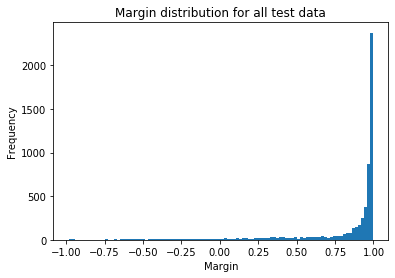

In [236]:
# Overall margin
plt.hist(x=df_test['margin'], bins=100)
plt.xlabel('Margin')
plt.ylabel('Frequency')
plt.title('Margin distribution for all test data')
plt.show()

### Margins for different groups of users

In [237]:
# Margins for different groups of users
df_anon = df_test.loc[df_test['user.type'] == '0'] 
df_new = df_test.loc[df_test['user.type'] == '1'] 
df_exp = df_test.loc[df_test['user.type'] == '2']

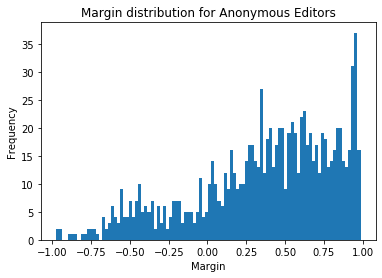

In [238]:
# Anon margin
plt.hist(x=df_anon['margin'], bins=100)
plt.xlabel('Margin')
plt.ylabel('Frequency')
plt.title('Margin distribution for Anonymous Editors')
plt.show()

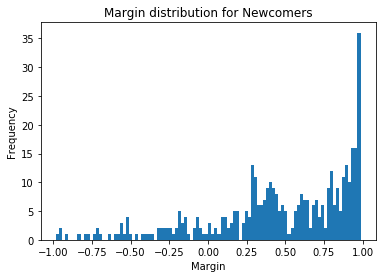

In [239]:
# Newcomers margin
plt.hist(x=df_new['margin'], bins=100)
plt.xlabel('Margin')
plt.ylabel('Frequency')
plt.title('Margin distribution for Newcomers')
plt.show()

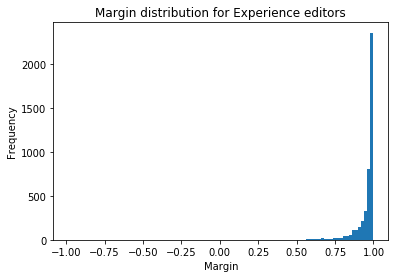

In [240]:
# Experience editors margin
plt.hist(x=df_exp['margin'], bins=100)
plt.xlabel('Margin')
plt.ylabel('Frequency')
plt.title('Margin distribution for Experience editors')
plt.show()

### Margins for different types of predictions

In [241]:
# Margins for different types of predictions
df_tp = df_test.loc[df_test['pred_type'] == 'TP'] 
df_tn = df_test.loc[df_test['pred_type'] == 'TN'] 
df_fp = df_test.loc[df_test['pred_type'] == 'FP'] 
df_fn = df_test.loc[df_test['pred_type'] == 'FN'] 

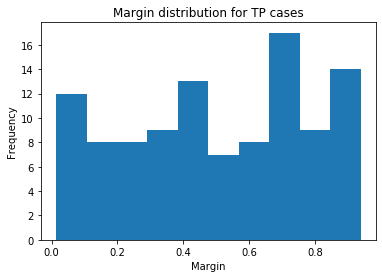

In [242]:
# TP margin
plt.hist(x=df_tp['margin'], bins=10)
plt.xlabel('Margin')
plt.ylabel('Frequency')
plt.title('Margin distribution for TP cases')
plt.show()

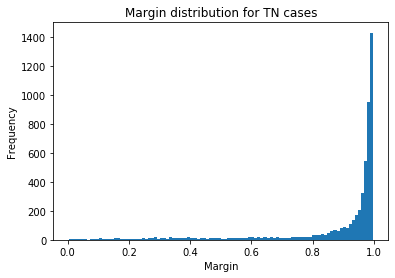

In [243]:
# TN margin
plt.hist(x=df_tn['margin'], bins=100)
plt.xlabel('Margin')
plt.ylabel('Frequency')
plt.title('Margin distribution for TN cases')
plt.show()

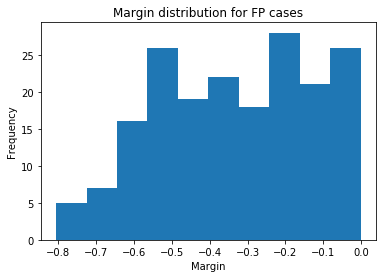

In [244]:
# FP margin
plt.hist(x=df_fp['margin'], bins=10)
plt.xlabel('Margin')
plt.ylabel('Frequency')
plt.title('Margin distribution for FP cases')
plt.show()

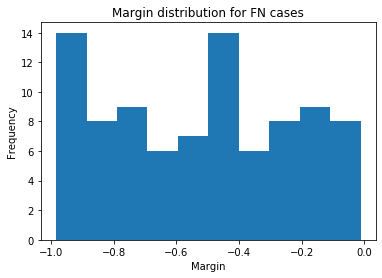

In [245]:
# FN margin
plt.hist(x=df_fn['margin'], bins=10)
plt.xlabel('Margin')
plt.ylabel('Frequency')
plt.title('Margin distribution for FN cases')
plt.show()

### Margins for different groups of users with same type of error